In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Install all neccessary libraries

In [ ]:
!pip install --upgrade torch

##Import all necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torch.nn import functional as F
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import WeightedRandomSampler

from torch import optim

from PIL import Image
import cv2

import os
import seaborn as sns

from fastprogress import master_bar, progress_bar

import matplotlib.pyplot as plt
import time

from torchvision.ops import sigmoid_focal_loss

##Set some neccessary hyperparameters

In [ ]:
IMAGE_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # Mean of ImageNet dataset
IMAGENET_STD = [0.229, 0.224, 0.225]  # Std of ImageNet dataset
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1
LEARNING_RATE_SCHEDULE_PATIENCE = 5
MAX_EPOCHS = 100
TRAINING_TIME_OUT = 3600*10

#Processing Dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/image_classification/dataset/train.csv")
print('tổng số mẫu train:', len(data))
data.head()

tổng số mẫu train: 3435


filename  opacity  diabetic retinopathy  glaucoma  macular edema  \
0  c24a1b14d253.jpg        0                     0         0              0   
1  9ee905a41651.jpg        0                     0         0              0   
2  3f58d128caf6.jpg        0                     0         1              0   
3  4ce6599e7b20.jpg        1                     0         0              0   
4  0def470360e4.jpg        1                     0         0              0   

   macular degeneration  retinal vascular occlusion  normal  
0                     0                           1       0  
1                     0                           1       0  
2                     0                           0       0  
3                     1                           0       0  
4                     1                           0       0

In [ ]:
folder_test = "/content/drive/MyDrive/image_classification/dataset/test/test"
files = [f for f in os.listdir(folder_test) if os.path.isfile(os.path.join(folder_test, f))]
print('tổng số mẫu test:', len(files))

tổng số mẫu test: 350


In [ ]:
LABELS = data.columns[1:]
print(LABELS)

Index(['opacity', 'diabetic retinopathy', 'glaucoma', 'macular edema',
       'macular degeneration', 'retinal vascular occlusion', 'normal'],
      dtype='object')


In [ ]:
LABEL_TO_INDEX = {}
INDEX_TO_LABEL = {}
for i in range(len(LABELS)):
    LABEL_TO_INDEX[LABELS[i]] = i
    INDEX_TO_LABEL[i] = LABELS[i]
print("LABEL_TO_INDEX:", LABEL_TO_INDEX)
print("INDEX_TO_LABEL:", INDEX_TO_LABEL)

LABEL_TO_INDEX: {'opacity': 0, 'diabetic retinopathy': 1, 'glaucoma': 2, 'macular edema': 3, 'macular degeneration': 4, 'retinal vascular occlusion': 5, 'normal': 6}
INDEX_TO_LABEL: {0: 'opacity', 1: 'diabetic retinopathy', 2: 'glaucoma', 3: 'macular edema', 4: 'macular degeneration', 5: 'retinal vascular occlusion', 6: 'normal'}


In [ ]:
# Alalyze distribution of 0 and 1 for each label
for label in data.columns[1:]:
    print("Distribution of", label)
    print(data[label].value_counts())

Distribution of opacity
opacity
0    1902
1    1533
Name: count, dtype: int64
Distribution of diabetic retinopathy
diabetic retinopathy
0    2680
1     755
Name: count, dtype: int64
Distribution of glaucoma
glaucoma
0    2838
1     597
Name: count, dtype: int64
Distribution of macular edema
macular edema
0    2919
1     516
Name: count, dtype: int64
Distribution of macular degeneration
macular degeneration
0    2861
1     574
Name: count, dtype: int64
Distribution of retinal vascular occlusion
retinal vascular occlusion
0    2995
1     440
Name: count, dtype: int64
Distribution of normal
normal
0    2910
1     525
Name: count, dtype: int64


In [ ]:
LABELS = data.columns[1:]
def build_label(row):
    return ",".join([LABELS[idx] for idx, val in enumerate(row[1:]) if val == 1])
data.apply(lambda x: build_label(x), axis=1).value_counts()

opacity                                                                  671
normal                                                                   525
glaucoma                                                                 327
macular degeneration                                                     299
opacity,macular degeneration                                             212
diabetic retinopathy                                                     212
opacity,diabetic retinopathy                                             186
retinal vascular occlusion                                               170
diabetic retinopathy,macular edema                                       162
opacity,diabetic retinopathy,macular edema                               154
opacity,glaucoma                                                         140
macular edema,retinal vascular occlusion                                  74
opacity,macular edema,retinal vascular occlusion                          62
opacity,retinal vascular occlusion                                        55
glaucoma,macular degeneration                                             31
macular edema                                                             27
glaucoma,retinal vascular occlusion                                       27
opacity,glaucoma,macular degeneration                                     16
diabetic retinopathy,glaucoma                                             15
glaucoma,macular edema,retinal vascular occlusion                         14
opacity,glaucoma,retinal vascular occlusion                               10
opacity,glaucoma,macular edema,retinal vascular occlusion                  8
diabetic retinopathy,retinal vascular occlusion                            5
opacity,diabetic retinopathy,macular degeneration                          5
opacity,diabetic retinopathy,retinal vascular occlusion                    4
glaucoma,macular edema                                                     3
diabetic retinopathy,glaucoma,macular edema                                3
opacity,macular degeneration,retinal vascular occlusion                    3
opacity,diabetic retinopathy,macular edema,macular degeneration            2
diabetic retinopathy,macular degeneration                                  2
opacity,diabetic retinopathy,macular edema,retinal vascular occlusion      2
macular degeneration,retinal vascular occlusion                            2
diabetic retinopathy,macular edema,retinal vascular occlusion              2
glaucoma,macular degeneration,retinal vascular occlusion                   2
opacity,macular edema                                                      2
opacity,diabetic retinopathy,glaucoma,macular edema                        1
Name: count, dtype: int64

In [ ]:
train_data, val_data = train_test_split(data, test_size=0.15, random_state=2024)

In [ ]:
# Calulator weight for each label
weight = []
pos_weight = []
positive = []
negative = []
for label in train_data.columns[1:]:
    count = 0
    for lb in train_data[label]:
        if lb == 1:
            count = count + 1
    print('count:', count)
    weight.append({label:count})
    pos_weight.append((len(train_data["filename"])-count)/count)
    positive.append(count/len(train_data["filename"]))
    negative.append(1-count/len(train_data["filename"]))
print(weight)
print(pos_weight)
print(positive)
print(negative)
print(len(train_data["filename"]))

count: 1323
count: 637
count: 502
count: 439
count: 499
count: 370
count: 428
[{'opacity': 1323}, {'diabetic retinopathy': 637}, {'glaucoma': 502}, {'macular edema': 439}, {'macular degeneration': 499}, {'retinal vascular occlusion': 370}, {'normal': 428}]
[1.2063492063492063, 3.5824175824175826, 4.814741035856573, 5.649202733485193, 4.849699398797595, 6.889189189189189, 5.820093457943925]
[0.45323741007194246, 0.2182254196642686, 0.17197670435080506, 0.15039397053785544, 0.17094895512161698, 0.12675573826652964, 0.14662555669749913]
[0.5467625899280575, 0.7817745803357314, 0.828023295649195, 0.8496060294621446, 0.829051044878383, 0.8732442617334704, 0.8533744433025009]
2919


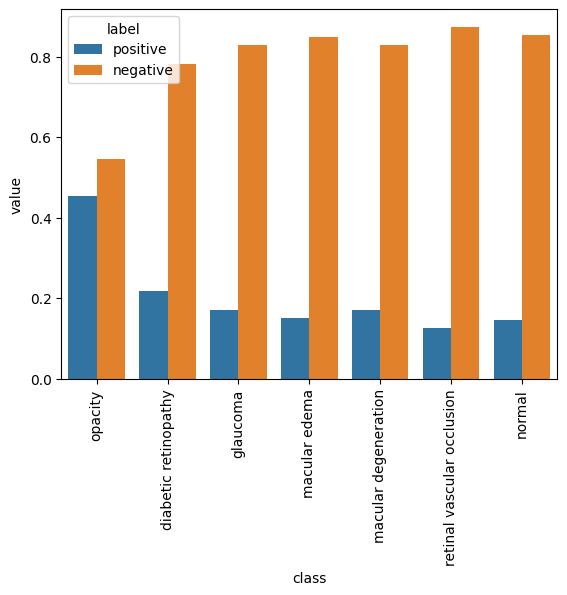

In [ ]:
df = pd.DataFrame({"class":train_data.columns[1:], "label":"positive", "value":positive})
df = pd.concat([df, pd.DataFrame([{"class":train_data.columns[1:][i], "label":"negative", "value":j} for i, j in enumerate(negative)])], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="class", y="value", hue="label" ,data=df)

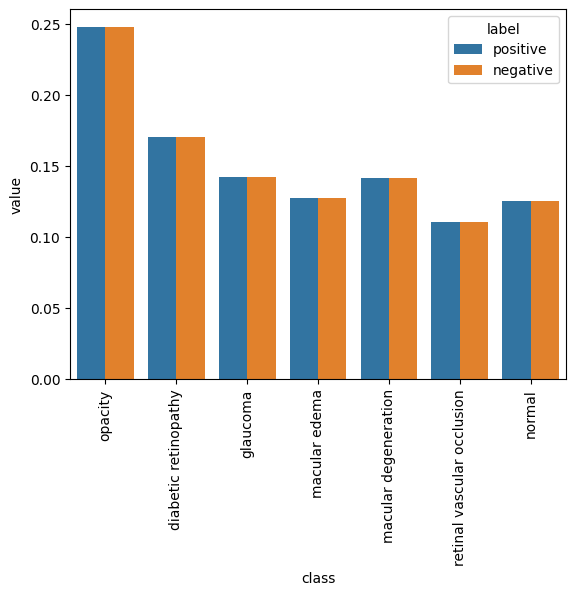

In [ ]:
pos_w = negative
neg_w = positive
pos_contribution = []
neg_contribution = []
for i in range(len(pos_w)):
    pos_contribution.append(pos_w[i]*positive[i])
    neg_contribution.append(neg_w[i]*negative[i])
df = pd.DataFrame({"class":data.columns[1:], "label":"positive", "value":pos_contribution})
df = pd.concat([df, pd.DataFrame([{"class":data.columns[1:][i], "label":"negative", "value":j} for i, j in enumerate(neg_contribution)])], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="class", y="value", hue="label" ,data=df)

#Preparing DataLoader, Train Valid Scenario

In [ ]:
class RetinaDataset(Dataset):

    def __init__(self, folder_dir, type_data, dataframe, image_size, normalization=True):
        self.image_paths = []
        self.image_labels = []
        self.type_data = type_data

        train_transformation = [
            transforms.Resize(image_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.2, 0.2))], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        ]

        val_transformation = [
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        ]

        if normalization:
            if self.type_data == "train":
                self.image_transformation = transforms.Compose(train_transformation)
            else:
                self.image_transformation = transforms.Compose(val_transformation)

        for index, row in dataframe.iterrows():
            image_path = os.path.join(folder_dir, row.filename)
            self.image_paths.append(image_path)
            labels = []
            for col in row[1:]:
                if col == 1:
                    labels.append(1)
                else:
                    labels.append(0)
            self.image_labels.append(labels)

    def __len__(self):
        return len(self.image_paths)

    def get_labels(self):
        label = self.image_labels
        return label

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image_data = Image.open(image_path).convert("RGB")
        image_data = self.image_transformation(image_data)
        return image_data, torch.FloatTensor(self.image_labels[index]), image_path

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


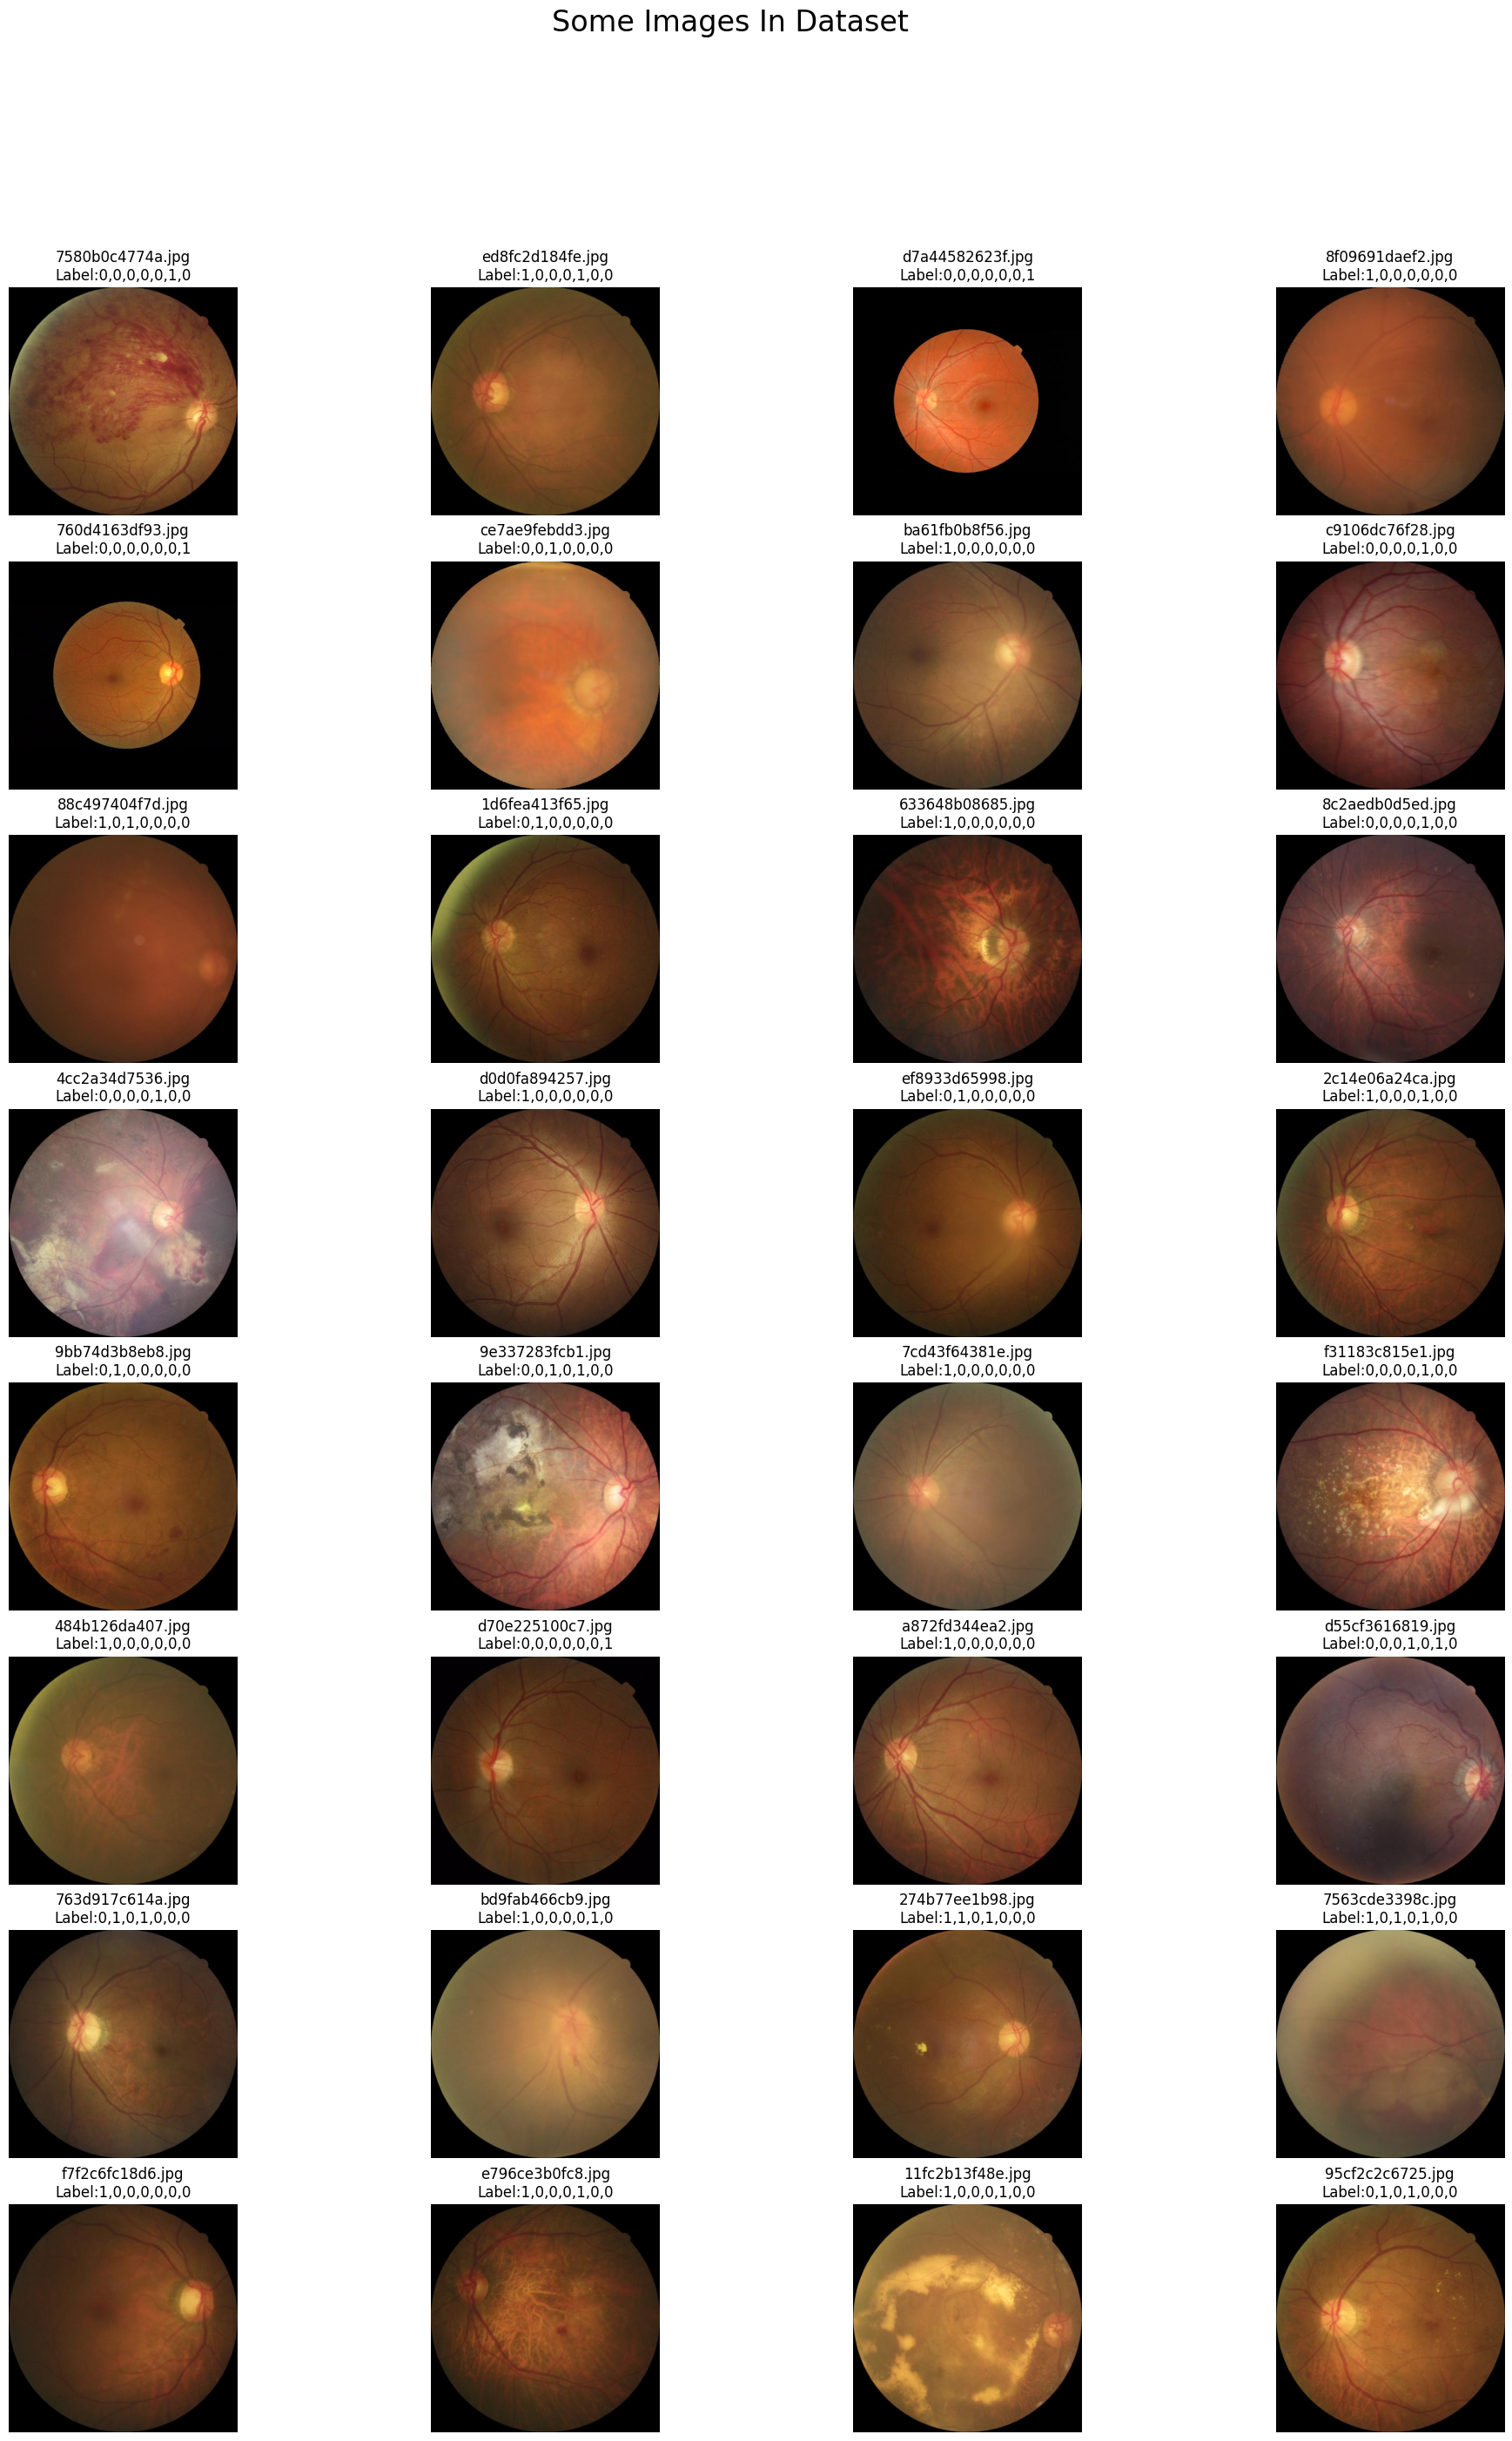

In [ ]:
#Create dataloader all dataset entries and show some examples
data_dataset = RetinaDataset('/content/drive/MyDrive/image_classification/dataset/train/train', 'train', data, (IMAGE_SIZE,IMAGE_SIZE), True)
data_dataloader = DataLoader(dataset=data_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
#Let's check the size of data and label for each iteration
for images, labels, paths in data_dataloader:
    nums_img = images.shape[0]
    cols = 4
    rows = nums_img//cols
    fig = plt.figure(figsize=(cols*6, rows*4))
    fig.suptitle("Some Images In Dataset", fontsize=24)
    for i in np.arange(rows):
        for j in np.arange(cols):
            index = (i*cols) + j
            path = paths[index]
            img = Image.open(path).convert("RGB")
            name = path.split('/')[-1]
            label = labels[index]
            title = name + '\nLabel:' + ','.join([str(int(i.numpy())) for i in label])

            plt.subplot(rows, cols, index+1)
            plt.title(title)
            plt.axis('off')
            plt.imshow(img)
    plt.show()
    break

In [ ]:
# calculator sample weight
labels = train_data.iloc[:, 1:].values
print('labels:', labels)
N, C = labels.shape
positive = labels.sum(axis=0)/N
negative = 1 - positive
print('test:', positive)
sample_weights = []
for i in range(N):
    pos_classes = np.where(labels[i] == 1)[0]
    if len(pos_classes) > 0:
        min_ratio = positive[pos_classes].min()
        weight = 1.0 / (min_ratio + 1e-6)
    else:
        weight = 1.0
    sample_weights.append(weight)
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights = sample_weights,
    num_samples = len(sample_weights),
    replacement = True
)

labels: [[1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]]
test: [0.45323741 0.21822542 0.1719767  0.15039397 0.17094896 0.12675574
 0.14662556]


In [ ]:
#Create train dataset and train dataloader
train_dataset = RetinaDataset('/content/drive/MyDrive/image_classification/dataset/train/train', 'train', train_data, (IMAGE_SIZE,IMAGE_SIZE), True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, sampler=sampler)

#Let's check the size of data and label for each iteration
for image_batch,label_batch,_ in train_dataloader:
    print(image_batch.size())
    print(label_batch.size())
    break

torch.Size([64, 3, 224, 224])
torch.Size([64, 7])


In [ ]:
#Create val dataset and val dataloader
val_dataset = RetinaDataset('/content/drive/MyDrive/image_classification/dataset/train/train', 'val', val_data, (IMAGE_SIZE,IMAGE_SIZE), True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=None, num_workers=4, pin_memory=True)

#Let's check the size of data and label for each iteration
for image_batch,label_batch,_ in val_dataloader:
    print(image_batch.size())
    print(label_batch.size())
    break

torch.Size([64, 3, 224, 224])
torch.Size([64, 7])


#Define Retina Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cpu


ResNet50

In [ ]:
class RetinaResnetModel(nn.Module):

    def __init__(self, num_classes, is_trained=True):
        super().__init__()
        self.net = torchvision.models.resnet.resnet50(pretrained=is_trained)
        classifier_input_size = self.net.fc.in_features
        self.net.fc = nn.Sequential(nn.Linear(classifier_input_size, num_classes), nn.Sigmoid())
    def forward(self, images):
        return self.net(images)

In [ ]:
model = RetinaResnetModel(num_classes=len(LABELS)).to(device)
model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


RetinaResnetModel(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [ ]:
#Number of trainable parameters
sum(p.numel() for p in model.parameters() if p.requires_grad)

23522375

#Loss function, optimize and score metrics

In [ ]:
loss_criteria = nn.BCELoss()
# weight loss
pos_weight = torch.tensor(pos_weight, device=device)
sqrt_pos_weight = torch.sqrt(pos_weight)
loss_weight = nn.BCEWithLogitsLoss(pos_weight=sqrt_pos_weight)
# focal loss
# focal_loss = sigmoid_focal_loss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR, patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max')


def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
         true_positive = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
         posible_positives =  np.sum(np.round(np.clip(y_true, 0, 1)))
         recall = true_positive/(posible_positives + np.finfo(float).eps)
         return recall
    def precision(y_true, y_pred):
         true_positive = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
         predicted_positives =  np.sum(np.round(np.clip(y_pred, 0, 1)))
         precision = true_positive/(predicted_positives + np.finfo(float).eps)
         return precision
    try:
        true_np = y_true.to("cpu").numpy()
        pred_np = y_pred.to("cpu").numpy()
    except:
        true_np = y_true.to("cpu").numpy()
        pred_np = y_pred.detach().cpu().numpy()
    precision = precision(true_np, pred_np)
    recall = recall(true_np, pred_np)
    return 2*((precision*recall)/(precision+recall+np.finfo(float).eps))

In [ ]:
def convert_list_tensor(origin):
    origin = torch.tensor(origin)  # Chuyển đổi danh sách thành tensor
    # Chuyển đổi các tensor từ GPU (cuda:0) sang CPU
    origin = origin.cpu()
    # Sử dụng các tensor đã chuyển đổi thành numpy array
    origin = origin.numpy()
    return origin

Training Pharse

In [ ]:
def training_pharse(model, train_dataloader, device, loss_criteria, loss_weight, type_loss, optimizer, mb):
    model.train()
    training_loss = 0.0
    out_pred = torch.FloatTensor().to(device)
    out_true = torch.FloatTensor().to(device)
    for batch, (images, labels, _) in enumerate(progress_bar(train_dataloader, parent=mb)):
        images = images.to(device)
        labels = labels.to(device)
        out_true = torch.cat((out_true,  labels), 0)

        optimizer.zero_grad()
        pred = model(images)
        if type_loss == 'loss_criteria':
            loss = loss_criteria(pred, labels)
        elif type_loss == 'loss_weight':
            loss = loss_weight(pred, labels)
        else:
            loss = sigmoid_focal_loss(pred, labels, 0.25, 2.0, reduction="mean")
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        out_pred = torch.cat((out_pred, pred), 0)

        mb.child.comment = f'Training loss {training_loss/(batch+1)}'
    del images, labels, loss
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return training_loss/len(train_dataloader), np.array(f1_score(out_true, out_pred)).mean()

In [ ]:
def evaluating(model, val_dataloader, device, loss_criteria, optimizer, mb):
    model.eval()
    val_loss = 0.0
    out_pred = torch.FloatTensor().to(device)
    out_true = torch.FloatTensor().to(device)
    with torch.no_grad():
        for batch, (images, labels, _) in enumerate(progress_bar(val_dataloader, parent=mb)):
            images = images.to(device)
            labels = labels.to(device)
            out_true = torch.cat((out_true,  labels), 0)
            pred = model(images)
            loss = loss_criteria
            val_loss += loss(pred, labels)
            out_pred = torch.cat((out_pred, pred), 0)
            mb.child.comment = f'Val loss {val_loss/(batch+1)}'
        del images, labels, loss
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return val_loss/len(val_dataloader),  np.array(f1_score(out_true, out_pred)).mean()

In [ ]:
def train(model, device, train_dataloader, val_dataloader, max_epochs, loss_criteria, loss_weight, type_loss, optimizer, lr_scheduler):

    best_score = 0.00
    train_losses = []
    train_score = []
    val_losses = []
    val_score = []

    mb = master_bar(range(max_epochs))
    mb.names = ['Training loss', 'Training F1-score', 'Validation loss', 'Validation F1-score']
    x = []

    start_time = time.time()
    nonimproved_epoch = 0

    for epoch in mb:
        mb.main_bar.comment = f'best f1 score: {best_score}'
        x.append(epoch)

        # training
        train_loss, f1_train = training_pharse(model, train_dataloader, device, loss_criteria, loss_weight, type_loss, optimizer, mb)
        train_losses.append(train_loss)
        train_score.append(f1_train)
        # evaluating
        val_loss, new_score = evaluating(model, val_dataloader, device, loss_criteria, optimizer, mb)
        val_losses.append(val_loss)
        val_score.append(new_score)
        mb.write('** Finish epoch {} | train loss: {:.4f} | train f1 score: {:.4f} | val loss: {:.4f} | val f1 score: {:.4f}'.format(epoch,train_loss, f1_train, val_loss, new_score))

        # update learning rate
        lr_scheduler.step(new_score)

        mb.update_graph([[x, convert_list_tensor(train_losses)], [x, convert_list_tensor(train_score)], [x, convert_list_tensor(val_losses)], [x, convert_list_tensor(val_score)]], [0,epoch+1], [0,1])

        if best_score < new_score:
            mb.write(f"Improve F1-Score from {np.round(best_score, 2)} to {np.round(new_score, 2)}")
            best_score = new_score
            nonimproved_epoch = 0
            # Save model if f1 score is improved
            torch.save({"model": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "best_score": best_score,
                        "epoch": epoch,
                        "lr_scheduler": lr_scheduler.state_dict()}, 'retina_best_score.pth')
        else:
            nonimproved_epoch += 1

        if nonimproved_epoch > 10:
            break
            print("Early stopping")
        if time.time() - start_time > TRAINING_TIME_OUT:
            break
            print("Out of time")

In [ ]:
# train(model, device, train_dataloader, val_dataloader, 60, loss_criteria, loss_weight, "loss_criteria", optimizer, lr_scheduler)
# print("training is done!")

In [ ]:
# model = RetinaResnetModel(num_classes=len(LABELS)).to(device)
# model
# train(model, device, train_dataloader, val_dataloader, 30, loss_criteria, loss_weight, "loss_weight", optimizer, lr_scheduler)
# print("training is done!")

In [ ]:
# model = RetinaResnetModel(num_classes=len(LABELS)).to(device)
# model
# train(model, device, train_dataloader, val_dataloader, 30, loss_criteria, loss_weight, "focal_loss", optimizer, lr_scheduler)
# print("training is done!")

Inference

In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/image_classification/dataset/sample_submission.csv")
test_data.head()

filename predicted
0  e742d34a26d4.jpg       0 0
1  b193b6a6d68d.jpg       0 0
2  07e4191fa3a8.jpg       0 0
3  b1a911cb2e6c.jpg       0 0
4  d8ab9cda1b33.jpg       0 0

In [ ]:
test_dataset = RetinaDataset('/content/drive/MyDrive/image_classification/dataset/test/test', 'test', test_data, (IMAGE_SIZE,IMAGE_SIZE), True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=None, num_workers=4, pin_memory=True)

#Let's check the size of data and label for each iteration
for image_batch,label_batch,_ in test_dataloader:
    print(image_batch.size())
    print(label_batch.size())
    break

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([1, 3, 224, 224])
torch.Size([1, 1])


In [ ]:
PATH_TRAINED_MODEL="/content/drive/MyDrive/image_classification/retina_best_score.pth"
model = RetinaResnetModel(num_classes=len(LABELS)).to(device)
model.load_state_dict(torch.load(PATH_TRAINED_MODEL, weights_only=False, map_location=device)['model'])
model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RetinaResnetModel(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [ ]:
def test_pharse(model, test_loader, device):
    model.eval()
    output_pred = torch.FloatTensor().to(device)
    with torch.no_grad():
        for step, (images, _, filename) in enumerate(progress_bar(test_dataloader)):
            images = images.to(device)
            pred = model(images)
            if step == 0:
                print(f'pred of {filename}:', pred, pred > 0.5)
            output_pred = torch.cat((output_pred, pred), 0)
        del images
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        return output_pred.to("cpu").numpy()

In [ ]:
out_pred = test_pharse(model, test_dataloader, device)
out_pred=(out_pred > 0.5)*1
print("-Number images:",len(test_data.filename))
print("-Output shape:",out_pred.shape)

pred of ('/content/drive/MyDrive/image_classification/dataset/test/test/e742d34a26d4.jpg',): tensor([[5.0806e-04, 3.6062e-04, 4.2513e-04, 6.9071e-04, 7.8955e-04, 5.6593e-04,
         9.9956e-01]]) tensor([[False, False, False, False, False, False,  True]])
-Number images: 350
-Output shape: (350, 7)


In [ ]:
predicts_metadata={}
predicts_metadata['filename']=test_data.filename
for i in np.arange(len(LABELS)):
  predicts_metadata[INDEX_TO_LABEL[i]]=out_pred[:,i]
predicts_df = pd.DataFrame(predicts_metadata)
predicts_df

filename  opacity  diabetic retinopathy  glaucoma  macular edema  \
0    e742d34a26d4.jpg        0                     0         0              0   
1    b193b6a6d68d.jpg        1                     0         0              0   
2    07e4191fa3a8.jpg        1                     0         0              0   
3    b1a911cb2e6c.jpg        1                     0         0              0   
4    d8ab9cda1b33.jpg        1                     0         1              0   
..                ...      ...                   ...       ...            ...   
345  c3d744001f2f.jpg        0                     0         0              0   
346  f7b9fdd3d7e1.jpg        1                     1         0              1   
347  937b3f57bea7.jpg        0                     1         0              0   
348  4caffcaefb29.jpg        1                     1         0              0   
349  efc0a0b72ad2.jpg        0                     0         1              0   

     macular degeneration  retinal vascular occlusion  normal  
0                       0                           0       1  
1                       1                           0       0  
2                       0                           0       0  
3                       0                           0       0  
4                       0                           0       0  
..                    ...                         ...     ...  
345                     0                           0       1  
346                     0                           0       0  
347                     0                           0       0  
348                     0                           0       0  
349                     0                           0       0  

[350 rows x 8 columns]

XAI

In [ ]:
!pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
def preprocessing(image, device):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])
    image = transform(image)
    image = image.to(device)
    return image


output: tensor([[1, 1, 0, 0, 0, 0, 0]])


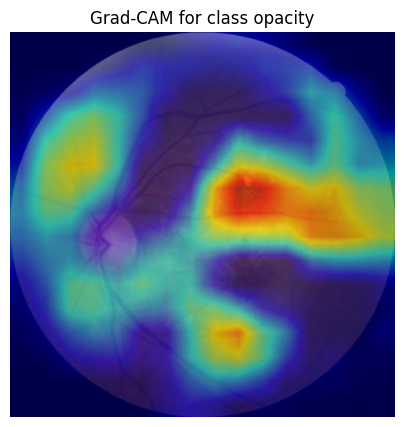

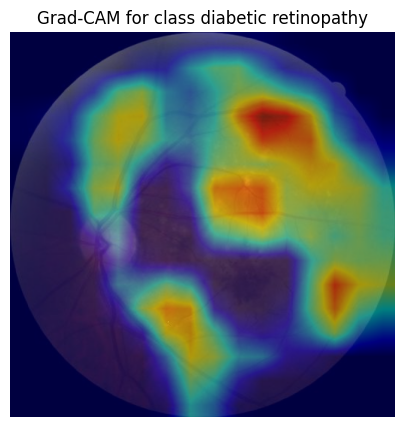

In [ ]:
target_layers = [model.net.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)
img_path = "/content/drive/MyDrive/image_classification/dataset/test/test/b193b6a6d68d.jpg"
original_image = Image.open(img_path).convert("RGB")

image_tensor = preprocessing(original_image, device)
if image_tensor.ndim == 3:
    image_tensor = image_tensor.unsqueeze(0)
results = {}

with torch.no_grad():
    output = model(image_tensor)
    print('output:', (output > 0.5)*1)

probs = output[0].cpu().numpy()
results = {}
for idx, label in enumerate(LABELS):
    if probs[idx] > 0.5:   # chỉ chạy cho nhãn dự đoán dương
        grayscale_cam = cam(
            input_tensor=image_tensor,
            targets=[ClassifierOutputTarget(idx)]
        )
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(
            np.array(original_image).astype(np.float32) / 255.0,
            grayscale_cam,
            use_rgb=True,
            image_weight=0.5  # điều chỉnh độ trong suốt (0.3 - 0.7)
        )
        results[label] = visualization

for cls_idx, vis in results.items():
    plt.figure(figsize=(5,5))
    plt.title(f"Grad-CAM for class {cls_idx}")
    plt.imshow(vis)
    plt.axis("off")
    plt.show()

In [ ]:
# check GradCAM
def GradCAM_test(model, original_image, grayscale_cam, target_class, steps=5, mode="deletion"):
    model.eval()
    image_tensor = preprocessing(original_image, device)
    H, W = grayscale_cam.shape
    grayscale_cam_flat = grayscale_cam.flatten()
    sorted_idx = np.argsort(-grayscale_cam_flat)
    mask = torch.zeros((H*W, ), dtype=torch.float32)
    probs = []
    c, h, w = image_tensor.shape
    b = 1
    mask_resized_first = mask.view(H, W).view(h, w)
    mask_resized_first = mask_resized_first.unsqueeze(0).unsqueeze(0)
    mask_resized_first = mask_resized_first.expand(b, c, h, w)
    with torch.no_grad():
        out_original = model(image_tensor.unsqueeze(0))
        out_original = out_original.squeeze(0)
        pred_classes = (out_original > 0.5).nonzero(as_tuple=True)[0]
        out_mask = model(mask_resized_first)
        out_mask = out_mask.squeeze(0)
        pred_mask = (out_mask > 0.5).nonzero(as_tuple=True)[0]

    # show original image or mask
    if mode == "deletion":
        plt.figure(figsize=(15, 3))
        plt.subplot(1, steps+2, 1)
        plt.imshow(original_image)
        plt.title(f"Original probs: {round(out_original[target_class].item(), 2)}")
        plt.axis("off")
    else:
        plt.figure(figsize=(15, 3))
        plt.subplot(1, steps+2, 1)
        plt.imshow(mask_resized_first.squeeze(0).permute(1,2,0).cpu().numpy())
        plt.title(f"mask probs: {round(out_mask[target_class].item(), 2)}")
        plt.axis("off")
    for s, i in enumerate(np.linspace(0, H*W, steps, endpoint=False, dtype=int)):
    # for s, i in enumerate(range(0, H*W, (H*W // steps))):
        mask[sorted_idx[i:i+(H*W)//steps]] = 1
        mask_2d = mask.view(H, W)
        mask_resized = mask_2d.view(h, w)
        if mode == "deletion":
            modified = image_tensor * (1 - mask_resized)
        else:
            modified = image_tensor * mask_resized
        img_modified = modified.permute(1,2,0).cpu().numpy()
        plt.subplot(1, steps+2, s+2)
        plt.imshow(img_modified)
        with torch.no_grad():
            out = model(modified.unsqueeze(0))
            out = out.squeeze(0)
            pred_classes = (out > 0.5).nonzero(as_tuple=True)[0]
            probs.append(np.round(out[target_class], 2))
        plt.title(f"Step {s+1}, prob: {round(out[target_class].item(), 2)}")
        plt.axis("off")
    plt.show()
    return probs

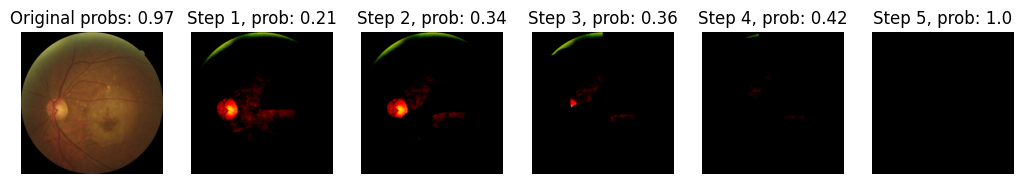

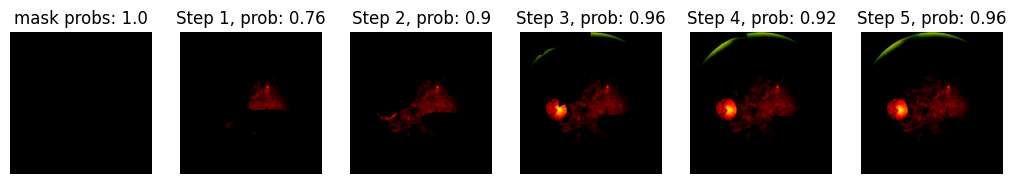

deletion_probs: [tensor(0.2100), tensor(0.3400), tensor(0.3600), tensor(0.4200), tensor(1.)]
insertion_probs: [tensor(0.7600), tensor(0.9000), tensor(0.9600), tensor(0.9200), tensor(0.9600)]


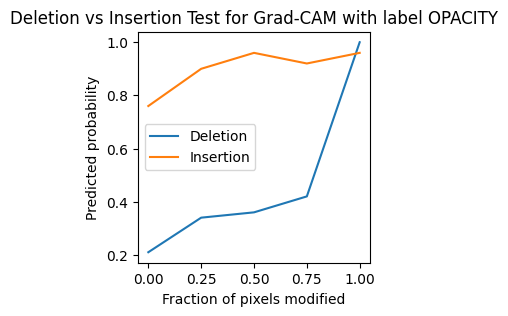

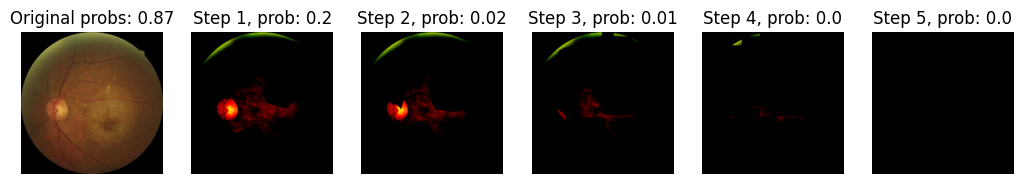

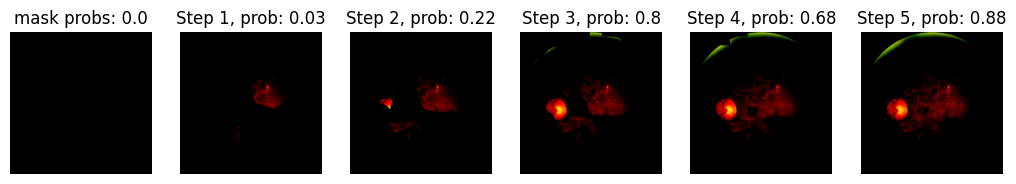

deletion_probs: [tensor(0.2000), tensor(0.0200), tensor(0.0100), tensor(0.), tensor(0.)]
insertion_probs: [tensor(0.0300), tensor(0.2200), tensor(0.8000), tensor(0.6800), tensor(0.8800)]


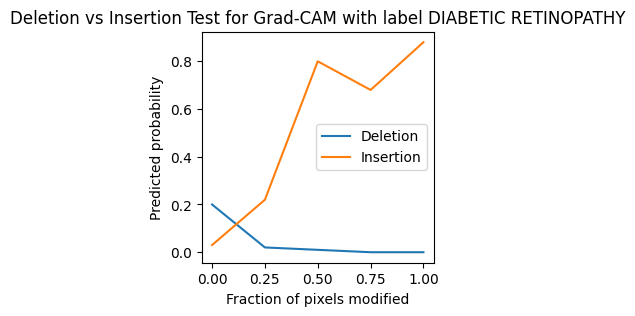

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.image")


for idx, label in enumerate(LABELS):
    if probs[idx] > 0.5:   # chỉ chạy cho nhãn dự đoán dương
        grayscale_cam = cam(
            input_tensor=image_tensor,
            targets=[ClassifierOutputTarget(idx)]
        )
        grayscale_cam = grayscale_cam[0, :]
        deletion_probs = GradCAM_test(model, original_image, grayscale_cam, idx, mode="deletion")
        insertion_probs = GradCAM_test(model, original_image, grayscale_cam, idx, mode="insertion")
        print('deletion_probs:', deletion_probs)
        print('insertion_probs:', insertion_probs)
        plt.figure(figsize=(3, 3))
        plt.plot(np.linspace(0, 1, len(deletion_probs)), deletion_probs, label="Deletion")
        plt.plot(np.linspace(0, 1, len(insertion_probs)), insertion_probs, label="Insertion")
        plt.xlabel("Fraction of pixels modified")
        plt.ylabel("Predicted probability")
        plt.legend()
        plt.title(f"Deletion vs Insertion Test for Grad-CAM with label {LABELS[idx].upper()}")
        plt.show()